# Cabernet, Anyone? Autopilot Does Text for Wine Reviews
Combining text with tabular data is one place Autopilot really shines. Now, let's learn how to update the classification levels based on our ROC results overnight!

First, please make sure to download the Wine Reviews dataset at the link below. Then, upload onto your notebook in the same directory as this file. 
- https://www.kaggle.com/zynicide/wine-reviews

In [ ]:
!apt-get install unzip -y
!unzip 1442_8172_compressed_winemag-data-130k-v2.csv.zip

In [ ]:
import pandas as pd

df = pd.read_csv('winemag-data-130k-v2.csv')
df.drop(['Unnamed: 0', 'taster_twitter_handle', 'taster_name'], inplace=True, axis=1)

df.head()

In [ ]:
def create_target(df, threshold):
    # looks at the target column, buckets it based on a threshold
    
    df['target'] = 0

    for idx, row in df.iterrows():

        points = row['points']

        if points >= threshold:
            df.at[idx, 'target'] = 1
    
    df.drop(['points'], inplace=True, axis=1)
    
    df = df.sample(frac=1)
    
    return df

df = create_target(df, threshold = 89)

df['target'].value_counts()

In [ ]:
# create train and test sets
train_split = 0.85
split_row = round(df.shape[0] * train_split)
train_set = df[:split_row]
test_set = df[split_row:]

# write to disk for autopilot
local_file = 'wine_review_train.csv'
train_set.to_csv(local_file, index=False, header=True)

# write to disk for use later 
test_set.to_csv('test_set.csv', index=False, header=True)

target_attribute_name = 'target'


In [ ]:
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from sagemaker import get_execution_role
import sagemaker
import utils as ut

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'wine-reviews-' + timestamp_suffix

role = get_execution_role()

sess = sagemaker.Session()

est_1 = AutoML(role=role,
                target_attribute_name=target_attribute_name,
                base_job_name = base_job_name, 
                sagemaker_session=sess,
                max_candidates=20)

est_1.fit(local_file, job_name=base_job_name, wait=False, logs=False)

Now, let's run some parallel batch transform jobs to get inference results on all of those models.

In [12]:
def get_predictions(job_name, top_n_candidates, test_set):
    
    est, candidates = ut.get_candidates(top_n_candidates, job_name )
    
    test_no_target = test_set.drop('target', axis=1)
    test_file = 'test_without_target.csv'
    test_no_target.to_csv(test_file, index=False, header=False)

    bucket = sess.default_bucket()
    prefix = 'transform'
    input_data_transform = sess.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
    print('Uploaded transform data to {}'.format(input_data_transform))

    transformers = ut.run_transform_jobs(bucket, prefix, est, candidates, input_data_transform)

    # this will wait until the last job is completed
    ut.wait_until_completion(transformers)

    # this copies inference results back from S3 and loads into memory
    predictions = ut.get_predictions(transformers, test_file)
    
    return predictions, candidates

predictions, transformers = get_predictions(job_name = '<paste in your first AutoML job name here>', top_n_candidates = 5, test_set = test_set)

In [ ]:
target_attribute_name = 'target'
target_attribute_true_value = 1
labels = test_set[target_attribute_name].apply(lambda row: True if row==target_attribute_true_value else False)

In [ ]:
ut.get_roc_curve(predictions, transformers, labels)

In [ ]:
ut.get_candidate_for_precision_at_recall(predictions, transformers, labels, target_min_precision = 0.75)

---
## Step Two - Retraining on a Modified Dataset
Now, just after we've deployed our model, our product team tells us they want us to focus on only wines outside of California. They want to test out the model on a different dataset, and believe that we need to produce a model without wines from California. Let's see how to do that, and how it changes our classification levels.

In [4]:
import pandas as pd
import sagemaker
import utils as ut


# pick up the train set in case our kernel halted
train_set = pd.read_csv('wine_review_train.csv')
test_set = pd.read_csv('test_set.csv')

no_cal_train = train_set[ train_set['province'] != 'California']
no_cal_test = test_set[ test_set['province'] != 'California']

local_file = 'no_cal_train.csv'
no_cal_train.to_csv(local_file, index=False, header=True)

In [9]:
from time import gmtime, strftime, sleep
from sagemaker import get_execution_role
from sagemaker import AutoML


timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'wine-reviews-no-cal' + timestamp_suffix

role = get_execution_role()

sess = sagemaker.Session()

est_2 = AutoML(role=role,
                target_attribute_name='target',
                base_job_name = base_job_name, 
                sagemaker_session=sess,
                max_candidates=20)

est_2.fit(local_file, job_name=base_job_name, wait=False, logs=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [13]:
predictions, candidates = get_predictions(job_name = '<paste in your second AutoML job name here>', top_n_candidates = 5, test_set = no_cal_test)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Uploaded transform data to s3://sagemaker-us-east-1-181880743555/transform/test_without_target.csv


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Starting transform job tuning-job-1-0988ed90ee1f45209c-014-154-2020-08-18-18-49-56-334
Starting transform job tuning-job-1-0988ed90ee1f45209c-013-6ba-2020-08-18-18-49-56-834
Starting transform job tuning-job-1-0988ed90ee1f45209c-012-230-2020-08-18-18-49-57-953
Starting transform job tuning-job-1-0988ed90ee1f45209c-011-3a3-2020-08-18-18-49-59-217
Starting transform job tuning-job-1-0988ed90ee1f45209c-010-5ff-2020-08-18-18-49-59-672
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
1 out of 5 transform jobs are running.
0 out of 5 transform jobs are running.
Transform job 'tuning-job-1-0988ed90ee1f45209c-014-154-2020-08-18-18-49-56-334' finished with sta

In [15]:
no_cal_labels = no_cal_test['target'].apply(lambda row: True if row==1 else False)

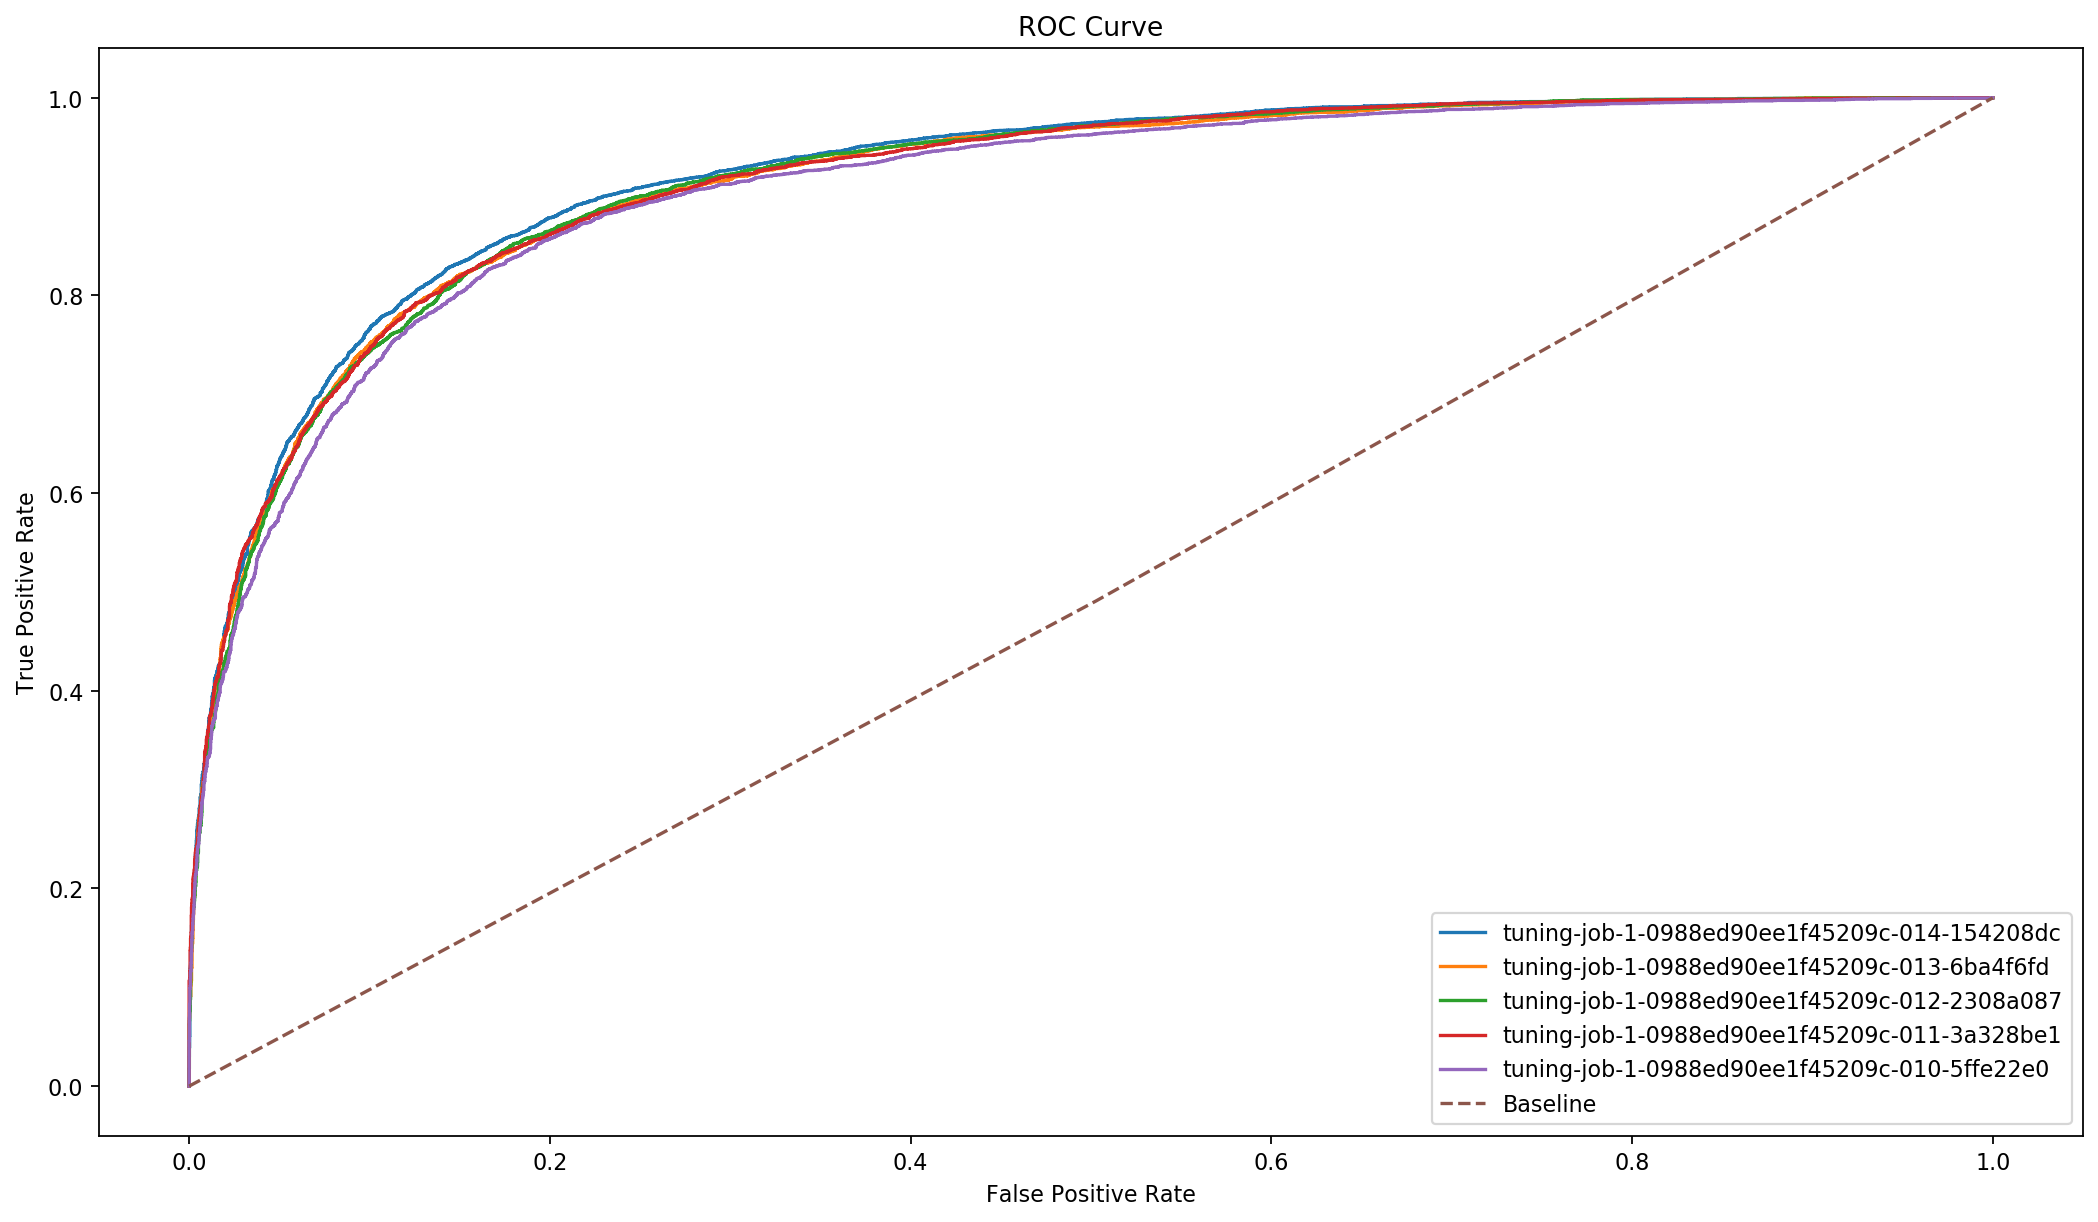

In [17]:
ut.get_roc_curve(predictions, candidates, no_cal_labels)

In [18]:
ut.get_candidate_for_precision_at_recall(predictions, candidates, no_cal_labels, target_min_precision = 0.75)

Best Candidate Name: tuning-job-1-0988ed90ee1f45209c-014-154208dc
Best Candidate Threshold (Operation Point): 0.17469505965709686
Best Candidate Recall: 0.9126047811238746
